In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import nltk

# Preprocessing dan modeling
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load data
data = pd.read_csv("Phishing_Email.csv")
print(data.head())

                                              sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                 Michael Parker <ivqrnai@pobox.com>   
4  Gretchen Suggs <externalsep1@loanofficertool.com>   

                                         receiver  \
0                     user4@gvc.ceas-challenge.cc   
1                   user2.2@gvc.ceas-challenge.cc   
2                   user2.9@gvc.ceas-challenge.cc   
3  SpamAssassin Dev <xrh@spamassassin.apache.org>   
4                   user2.2@gvc.ceas-challenge.cc   

                              date  \
0  Tue, 05 Aug 2008 16:31:02 -0700   
1  Tue, 05 Aug 2008 18:31:03 -0500   
2  Tue, 05 Aug 2008 20:28:00 -1200   
3  Tue, 05 Aug 2008 17:31:20 -0600   
4  Tue, 05 Aug 2008 19:31:21 -0400   

                                             subject  \
0                          Never agree to be a loser   
1  

In [3]:
# Data Understanding
print("Jumlah baris data:", len(data))

Jumlah baris data: 39154


In [4]:
print(data.columns)

Index(['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls'], dtype='object')


In [5]:
# Panjang rata-rata teks
data['text_length'] = data['body'].astype(str).apply(len)
print("Panjang rata-rata setiap baris:", data['text_length'].mean())

Panjang rata-rata setiap baris: 1571.0798130459211


In [6]:
# Cek duplikasi
print("Jumlah data duplikat:", data.duplicated().sum())

Jumlah data duplikat: 0


In [7]:
# Cek data kosong
print("Jumlah data kosong:\n", data.isnull().sum())

Jumlah data kosong:
 sender           0
receiver       462
date             0
subject         28
body             0
label            0
urls             0
text_length      0
dtype: int64


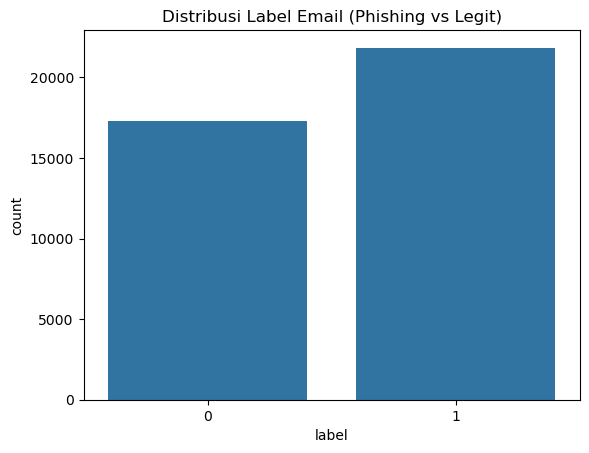

In [8]:
# Distribusi label
sns.countplot(x='label', data=data)
plt.title('Distribusi Label Email (Phishing vs Legit)')
plt.show()

In [9]:
# WordCloud dari isi email
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [10]:
# Gabungkan semua teks email
text_all = " ".join(data['body'].astype(str))

In [11]:
# Gabungkan semua teks email
text_all = " ".join(data['body'].astype(str))

In [12]:
# Buat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

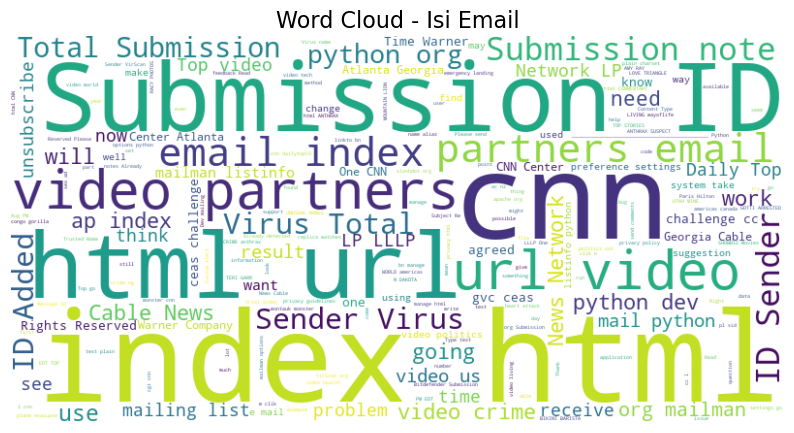

In [13]:
# Tampilkan hasilnya
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Isi Email", fontsize=16)
plt.show()

In [14]:
# Data Text Processing
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

data['clean_text'] = data['body'].astype(str).apply(clean_text)

In [15]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

data['clean_text'] = data['clean_text'].apply(preprocess)

In [16]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['clean_text']).toarray()
y = data['label']

In [17]:
# Split Data (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Modeling (Deep Learning - LSTM)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['clean_text'])
X_seq = tokenizer.texts_to_sequences(data['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=200)

In [19]:
# Split ulang untuk LSTM
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [20]:
# Model LSTM
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Training
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
392/392 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.9734 - loss: 0.0848 - val_accuracy: 0.9927 - val_loss: 0.0309
Epoch 2/5
392/392 ━━━━━━━━━━━━━━━━━━━━ 317s 808ms/step - accuracy: 0.9932 - loss: 0.0251 - val_accuracy: 0.9907 - val_loss: 0.0286
Epoch 3/5
392/392 ━━━━━━━━━━━━━━━━━━━━ 315s 803ms/step - accuracy: 0.9951 - loss: 0.0192 - val_accuracy: 0.9927 - val_loss: 0.0292
Epoch 4/5
392/392 ━━━━━━━━━━━━━━━━━━━━ 361s 903ms/step - accuracy: 0.9969 - loss: 0.0119 - val_accuracy: 0.9922 - val_loss: 0.0284
Epoch 5/5
392/392 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - accuracy: 0.9979 - loss: 0.0093 - val_accuracy: 0.9920 - val_loss: 0.0289


In [22]:
# Evaluasi Model
y_pred = (model.predict(X_test) > 0.5).astype("int32")

245/245 ━━━━━━━━━━━━━━━━━━━━ 44s 170ms/step


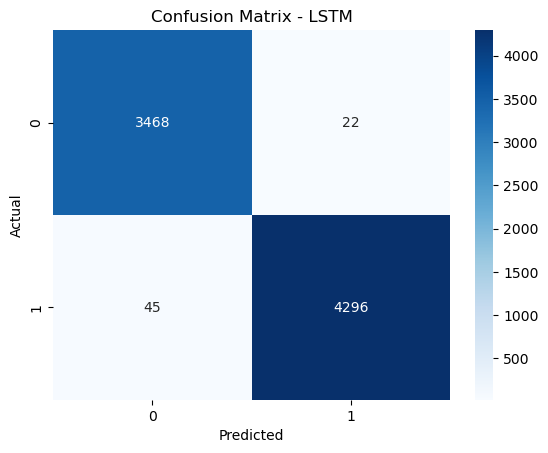

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3490
           1       0.99      0.99      0.99      4341

    accuracy                           0.99      7831
   macro avg       0.99      0.99      0.99      7831
weighted avg       0.99      0.99      0.99      7831



In [25]:
# Perbandingan dengan Model ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [26]:
# Gunakan TF-IDF hasil sebelumnya
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier()
lr = LogisticRegression(max_iter=1000)

rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

rf_acc = accuracy_score(y_test, rf.predict(X_test))
lr_acc = accuracy_score(y_test, lr.predict(X_test))
lstm_acc = accuracy_score(y_test, y_pred)

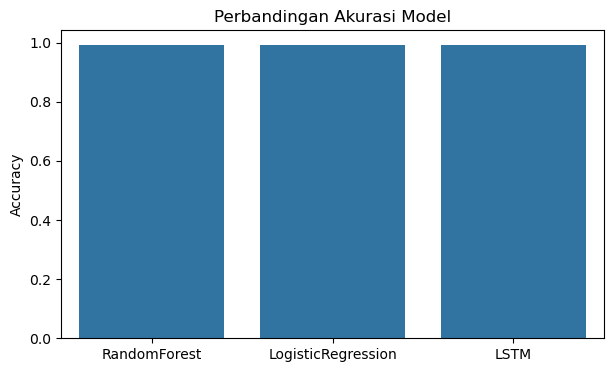

Akurasi RF: 0.992
Akurasi LR: 0.991
Akurasi LSTM: 0.991


In [27]:
# Bar chart
plt.figure(figsize=(7,4))
sns.barplot(x=['RandomForest', 'LogisticRegression', 'LSTM'],
            y=[rf_acc, lr_acc, lstm_acc])
plt.title("Perbandingan Akurasi Model")
plt.ylabel("Accuracy")
plt.show()

print(f"Akurasi RF: {rf_acc:.3f}")
print(f"Akurasi LR: {lr_acc:.3f}")
print(f"Akurasi LSTM: {lstm_acc:.3f}")